<a href="https://colab.research.google.com/github/jianfeiZhao/Machine-Learning-basic/blob/master/mnist_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


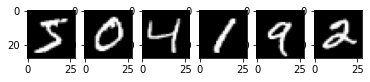

In [29]:
import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
#%matplotlib inline

# 超参数定义
EPOCH = 1
BATCH_SIZE = 64
TIME_STEP = 28
INPUT_SIZE = 28
LR = 0.003

# MNIST数据集下载
train_data = datasets.MNIST(root='./mnist', train=True, 
               transform=transforms.ToTensor(),
               download = True)
test_data = datasets.MNIST(root='./mnist', train=False, 
               transform=transforms.ToTensor(),
               download = False)

test_x = test_data.test_data.type(torch.FloatTensor)[:2000] / 255.
test_y = test_data.test_labels.numpy()[:2000]

print(train_data.train_data.size())
print(train_data.train_labels.size())
for i in range(6):
 plt.subplot(1,6,i+1)
 plt.imshow(train_data.train_data[i].numpy(), cmap='gray')
plt.show()

Epoch: 0, Step: 0, loss: 2.3192813396453857, accuracy: 0.109
Epoch: 0, Step: 100, loss: 0.9669036269187927, accuracy: 0.6505
Epoch: 0, Step: 200, loss: 0.5616973042488098, accuracy: 0.8235
Epoch: 0, Step: 300, loss: 0.4185424745082855, accuracy: 0.876
Epoch: 0, Step: 400, loss: 0.1900617778301239, accuracy: 0.8955
Epoch: 0, Step: 500, loss: 0.11270291358232498, accuracy: 0.923
Epoch: 0, Step: 600, loss: 0.162417471408844, accuracy: 0.9075
Epoch: 0, Step: 700, loss: 0.12809400260448456, accuracy: 0.9245
Epoch: 0, Step: 800, loss: 0.13790859282016754, accuracy: 0.9265
Epoch: 0, Step: 900, loss: 0.04460698366165161, accuracy: 0.9435
real numbers:


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


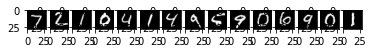

Predict numbers: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1]


In [30]:
# 使用Dataloader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# 定义网络
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.GRU(input_size=INPUT_SIZE, hidden_size=64, num_layers=1, batch_first=True)
        self.out = nn.Linear(64, 10) #10个分类

    def forward(self, x):
        # 前向传播
        r_out, _ = self.rnn(x)
        # 选择 r_out的最后一个时间步
        out = self.out(r_out[:,-1,:])
        return out

# 设置使用GPU
cuda = torch.device('cuda')
rnn = RNN()
rnn = rnn.cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

# 训练&验证
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x = b_x.view(-1, 28, 28)
        # 前向传播
        output = rnn(b_x.cuda())
        # 损失函数
        loss = loss_func(output, b_y.cuda())
        # 后向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            test_output = rnn(test_x.cuda())
            pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()
            # 计算准确率
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print ('Epoch: {}, Step: {}, loss: {}, accuracy: {}'.format(epoch, step, loss, accuracy))

# 从测试集选出10个，进行验证
test_x = test_x.cuda()
test_output = rnn(test_x[:15].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()
print('real numbers:')
for i in range(15):
 plt.subplot(1,15,i+1)
 plt.imshow(test_data.test_data[i].numpy(), cmap='gray')
plt.show()
print('Predict numbers:', pred_y)